## 1. Análise exploratória de dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('consumo_energia.txt', delimiter = ';')

In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [5]:
df.isnull().sum().sort_values(ascending=False).head() 

Sub_metering_3           25979
Date                         0
Time                         0
Global_reactive_power        0
Global_active_power          0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
#df = df.drop(['Date', 'Time'], axis=1)
df = df.iloc[0:, 2:9].dropna()

In [8]:
df['Voltage'] = df['Voltage'].astype(dtype = 'float64')
df['Global_active_power'] = df['Global_active_power'].astype(dtype = 'float64')
df['Global_reactive_power'] = df['Global_reactive_power'].astype(dtype = 'float64')
df['Global_intensity'] = df['Global_intensity'].astype(dtype = 'float64')
df['Sub_metering_1'] = df['Sub_metering_1'].astype(dtype = 'float64')
df['Sub_metering_2'] = df['Sub_metering_2'].astype(dtype = 'float64')
df['Sub_metering_3'] = df['Sub_metering_3'].astype(dtype = 'float64')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049280 entries, 0 to 2075258
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.1 MB


## 2. Criação do modelo

In [10]:
df_atrib = df.values

In [11]:
amostra_1, amostra_2 = train_test_split(df_atrib, train_size = .01)

print(f'Tamanho total da amostra: {amostra_1.shape}')

Tamanho total da amostra: (20492, 7)


In [12]:
normalizar = MinMaxScaler()
df_atrib = normalizar.fit_transform(df_atrib)

In [13]:
# Transforma as 7 variáveis em 2 variaveis principais.

pca = PCA(n_components = 2).fit_transform(amostra_1)

In [14]:
# Range do hiperparametro K.

k_range = range(1,12)

In [15]:
# Aplicando o modelo K-Means para cada valor de K.

k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

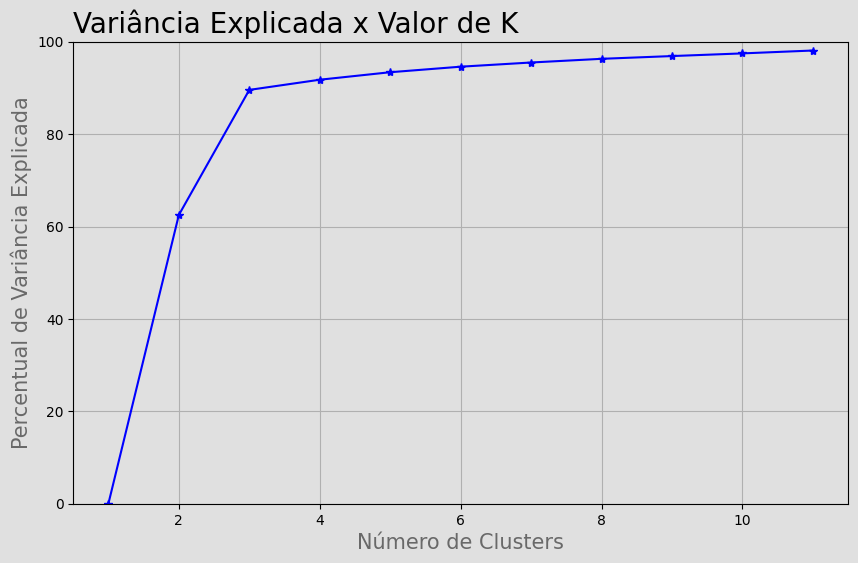

In [16]:
# Criando a curva Elbow

# Ajustando o centróide do cluster para cada modelo.
centroids = [X.cluster_centers_ for X in k_means_var]
 
#Calculando a distância euclidiana de cada ponto de dado para o centróide.
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Soma dos quadrados das distâncias dentro do cluster.
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Soma total dos quadrados.
soma_total = sum(pdist(pca)**2)/pca.shape[0]

# Soma dos quadrados entre clusters.
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

# Curva de Elbow
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0, 100))
plt.grid(True)

plt.xlabel('Número de Clusters', fontsize=15, color='#696969')
plt.ylabel('Percentual de Variância Explicada', fontsize=15, color='#696969')
plt.title('Variância Explicada x Valor de K', fontsize=20, loc='left')

plt.gca().set_facecolor('#E0E0E0')
plt.gcf().set_facecolor('#E0E0E0')

plt.show()

## 3. Avaliação do modelo com diferentes valores de K

### Valor de K = 8

In [17]:
modelo_v1 = KMeans(n_clusters = 8)
modelo_v1.fit(pca)

KMeans()

In [18]:
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

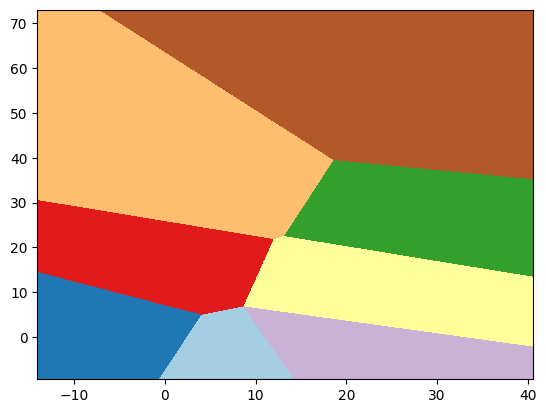

In [19]:
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

In [20]:
# O melhor modelo é de valor 1 e o pior é o valor de -1.

labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

np.float64(0.776275822864904)

### Valor de K = 9

In [21]:
modelo_v2 = KMeans(n_clusters = 9)
modelo_v2.fit(pca)

KMeans(n_clusters=9)

In [22]:
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

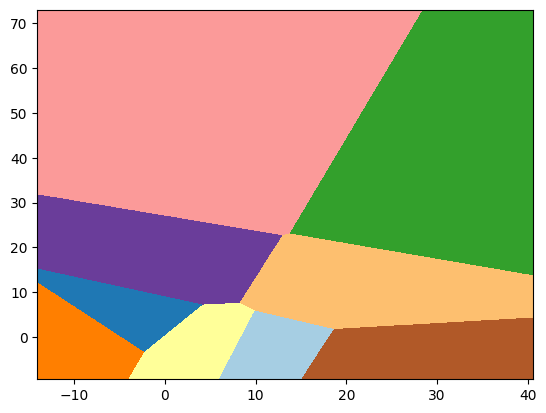

In [23]:
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

In [24]:
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

np.float64(0.665854204469472)

### Valor de K = 10

In [25]:
modelo_v3 = KMeans(n_clusters = 10)
modelo_v3.fit(pca)

KMeans(n_clusters=10)

In [26]:
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

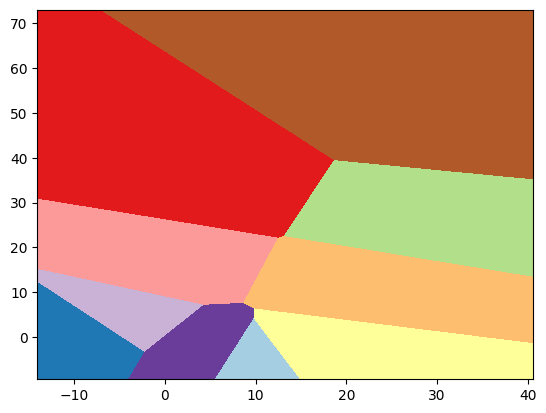

In [27]:
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

In [28]:
labels = modelo_v3.labels_
silhouette_score(pca, labels, metric = 'euclidean')

np.float64(0.6400639987132207)

### Valor de K = 11

In [29]:
modelo_v4 = KMeans(n_clusters = 11)
modelo_v4.fit(pca)

KMeans(n_clusters=11)

In [30]:
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v4.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

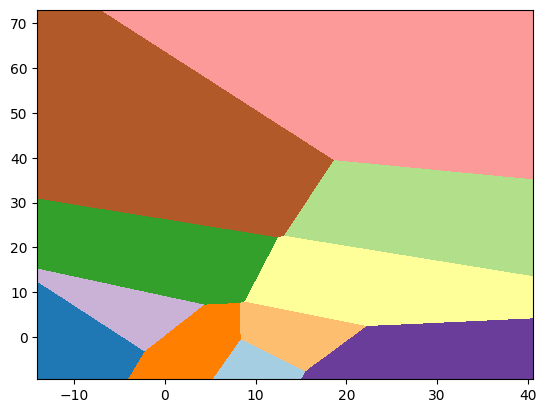

In [31]:
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

In [32]:
labels = modelo_v4.labels_
silhouette_score(pca, labels, metric = 'euclidean')

np.float64(0.6281547515159907)

## Máquina preditiva final

In [33]:
# Nomes das colunas.

names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [34]:
cluster_map = pd.DataFrame(amostra_1, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v1.labels_

In [35]:
cluster_map.groupby('cluster')['Global_active_power'].mean()

cluster
0    1.569540
1    0.506818
2    4.446046
3    2.543672
4    3.389020
5    2.912097
6    3.772592
7    6.270585
Name: Global_active_power, dtype: float64

In [36]:
cluster_map.groupby('cluster')['Global_active_power'].count()

cluster
0     5377
1    12943
2      305
3      250
4      202
5     1114
6      260
7       41
Name: Global_active_power, dtype: int64